In [ ]:
!pip install librosa

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
drive.mount('/content/drive')
PATH_FOLDER_AUDIO = '/content/drive/MyDrive/Sampel Rekaman Deep Learning'
# Menggunakan os.path.join untuk membuat path pencarian yang aman
# Ini akan mencari semua file yang berakhiran .m4a di dalam folder tersebut
search_pattern = os.path.join(PATH_FOLDER_AUDIO, '*.m4a')
file_paths = glob.glob(search_pattern)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_list = []
for file_path in file_paths:
    filename_with_ext = os.path.basename(file_path)
    label = os.path.splitext(filename_with_ext)[0]
    data_list.append({
        'audio': file_path,  # Path lengkap ke file
        'label': label       # Nama file tanpa ekstensi
    })
df = pd.DataFrame(data_list)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
df.head()

,audio,label,label_encoded
0,/content/drive/MyDrive/Sampel Rekaman Deep Lea...,Najla_Juwairia,15
1,/content/drive/MyDrive/Sampel Rekaman Deep Lea...,Marleta_Cornelia,12
2,/content/drive/MyDrive/Sampel Rekaman Deep Lea...,Rafa_Aqilla,18
3,/content/drive/MyDrive/Sampel Rekaman Deep Lea...,Johanes,11
4,/content/drive/MyDrive/Sampel Rekaman Deep Lea...,Afifah,0


In [ ]:
# ===================================================================
# --- LANGKAH WAJIB: Install FFMPEG (jika belum) ---
# ===================================================================
# Jalankan ini untuk memastikan librosa bisa membaca .m4a
!apt-get install -y ffmpeg

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation,
    MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
from tqdm.auto import tqdm

# ===================================================================
# --- PENGATURAN & KONFIGURASI MODEL ---
# ===================================================================
# (Kita gunakan 'df' dan 'label_encoder' DARI KODE ANDA SEBELUMNYA)

# Direktori untuk menyimpan model
SAVE_DIR = "./speaker_recognition_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# Path untuk file tes (ganti jika perlu)
TEST_AUDIO_FILE = "/content/drive/MyDrive/Marleta_Cornelia.m4a"

# --- Konfigurasi Audio ---
SAMPLE_RATE = 16000
CHUNK_DURATION_S = 2
N_MFCC = 20
N_FFT = 512
HOP_LENGTH = 256
CHUNK_SAMPLES = int(SAMPLE_RATE * CHUNK_DURATION_S) # 32000
EXPECTED_FRAMES = 126 # (Perhitungan 1 + 32000 // 256)

# ===================================================================
# --- FUNGSI EKSTRAKSI FITUR (Helper Function) ---
# ===================================================================
def extract_features_from_file(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
    except Exception as e:
        print(f"Error memuat {file_path}: {e}")
        return []

    if len(audio) < CHUNK_SAMPLES:
        audio = np.pad(audio, (0, CHUNK_SAMPLES - len(audio)), 'constant')

    features_list = []
    hop_chunk = CHUNK_SAMPLES // 2

    for start in range(0, len(audio) - CHUNK_SAMPLES + 1, hop_chunk):
        chunk = audio[start : start + CHUNK_SAMPLES]
        mfcc = librosa.feature.mfcc(
            y=chunk, sr=SAMPLE_RATE, n_mfcc=N_MFCC,
            n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mfcc_transposed = mfcc.T
        if mfcc_transposed.shape == (EXPECTED_FRAMES, N_MFCC):
            features_list.append(mfcc_transposed)
    return features_list

# ===================================================================
# --- (FUNGSI BUILD MODEL & PREDIKSI) ---
# ===================================================================
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

def identify_speaker(audio_path, model, label_encoder_obj):
    try:
        audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)
        if len(audio) < CHUNK_SAMPLES:
            audio = np.pad(audio, (0, CHUNK_SAMPLES - len(audio)), 'constant')
        else:
            audio = audio[:CHUNK_SAMPLES]
        mfcc = librosa.feature.mfcc(
            y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC,
            n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mfcc_t = mfcc.T
        if mfcc_t.shape != (EXPECTED_FRAMES, N_MFCC):
            mfcc_t = tf.image.resize(
                np.expand_dims(mfcc_t, axis=-1),
                [EXPECTED_FRAMES, N_MFCC]
            ).numpy().squeeze()
        mfcc_batch = np.expand_dims(mfcc_t, axis=0)
        predictions = model.predict(mfcc_batch)[0]
        sorted_indices = np.argsort(predictions)[::-1]
        results = []
        for i in sorted_indices:
            speaker_name = label_encoder_obj.inverse_transform([i])[0]
            probability = predictions[i]
            results.append((speaker_name, probability))
        return results
    except Exception as e:
        print(f"Error saat identifikasi {audio_path}: {e}")
        return None

# ===================================================================
# --- LANGKAH 2: EKSTRAKSI FITUR (Chunking & MFCC) ---
# ===================================================================
print("\n--- LANGKAH 2: Memproses dataset (Chunking & Ekstraksi MFCC) ---")

all_X = []
all_y = []

for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Ekstraksi Fitur"):
    file_path = row['audio']
    label = row['label_encoded']
    try:
        features = extract_features_from_file(file_path)
        if features:
            all_X.extend(features)
            all_y.extend([label] * len(features))
    except Exception as e:
        print(f"Gagal memproses {file_path}: {e}")

X = np.array(all_X)
y = np.array(all_y)

if X.shape[0] == 0:
    print("\nFATAL ERROR: Tidak ada data yang berhasil diproses.")
    # exit()
else:
    print(f"\nSelesai memproses data.")
    print(f"Total sampel 2 detik yang dibuat: {X.shape[0]}")
    print(f"Bentuk data X (fitur): {X.shape}")
    print(f"Bentuk data y (label): {y.shape}")

# ===================================================================
# --- LANGKAH 2.5: PERBAIKAN UNTUK 'STRATIFY' (FIX) ---
# ===================================================================
print("\n--- LANGKAH 2.5: Memeriksa dan Memperbaiki Data untuk Stratify ---")
# Hitung jumlah sampel untuk setiap kelas
class_counts = np.bincount(y)

# Cari kelas (speaker) yang HANYA punya 1 sampel
lonely_classes = np.where(class_counts == 1)[0]

if len(lonely_classes) > 0:
    print(f"WARNING: Ditemukan {len(lonely_classes)} speaker yang HANYA punya 1 sampel data (chunk).")
    print(f"Speaker tersebut adalah (label): {lonely_classes}")
    print("Ini terjadi karena file audio mereka sangat pendek.")
    print("Menduplikasi sampel untuk speaker ini agar split 'stratify' bisa berjalan...")

    X_to_add = []
    y_to_add = []

    for class_label in lonely_classes:
        # Cari indeks dari sampel satu-satunya itu
        sample_index = np.where(y == class_label)[0][0]

        # Tambahkan data X dan y-nya ke daftar
        X_to_add.append(X[sample_index])
        y_to_add.append(y[sample_index])

    # Gabungkan data duplikat ke X dan y
    X = np.concatenate((X, np.array(X_to_add)), axis=0)
    y = np.concatenate((y, np.array(y_to_add)), axis=0)

    print(f"\nBentuk data X (fitur) SETELAH diduplikasi: {X.shape}")
    print(f"Bentuk data y (label) SETELAH diduplikasi: {y.shape}")

else:
    print("Semua speaker memiliki 2 sampel atau lebih. Data aman.")

# ===================================================================
# --- LANGKAH 3: SPLIT DATA ---
# ===================================================================
print("\n--- LANGKAH 3: Membagi data (Train/Test Split) ---")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data Latih (Train): {X_train.shape}, {y_train.shape}")
print(f"Data Uji (Test):   {X_test.shape}, {y_test.shape}")

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

# ===================================================================
# --- LANGKAH 4: DEFINISI MODEL 1D CNN ---
# ===================================================================
print("\n--- LANGKAH 4: Mendefinisikan arsitektur 1D CNN (Versi Ringan) ---")

def build_model_tiny(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # --- Blok 1 (Filter dikurangi drastis: 64 -> 16) ---
    x = Conv1D(16, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # --- Blok 2 (Filter dikurangi: 128 -> 32) ---
    x = Conv1D(32, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # --- Blok 3 (Filter dikurangi: 256 -> 64) ---
    x = Conv1D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # --- Global Pooling & Output ---
    # Menghapus Dense Layer besar di tengah untuk mengurangi parameter
    x = GlobalAveragePooling1D()(x)

    # Dropout diperbesar sedikit untuk dataset kecil
    x = Dropout(0.6)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Inisialisasi Model Baru
num_classes = len(label_encoder.classes_)
model = build_model_tiny(INPUT_SHAPE, num_classes)

# Tampilkan ringkasan (Perhatikan 'Total params' akan turun drastis)
model.summary()
# ===================================================================
# --- LANGKAH 5: KOMPILASI DAN PELATIHAN MODEL ---
# ===================================================================
print("\n--- LANGKAH 5: Kompilasi dan Latih Model ---")
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_path = os.path.join(SAVE_DIR, 'best_model_tiny.h5')
callbacks = [
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

print(f"\nPelatihan selesai. Model terbaik DISIMPAN di: {model_path}")

# ===================================================================
# --- LANGKAH 6: EVALUASI MODEL ---
# ===================================================================
print("\n--- LANGKAH 6: Evaluasi Model pada Data Uji ---")
model.load_weights(model_path)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

--- LANGKAH 2: Memproses dataset (Chunking & Ekstraksi MFCC) ---


Ekstraksi Fitur:   0%|          | 0/22 [00:00<?, ?it/s]

/tmp/ipython-input-3133014893.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3133014893.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3133014893.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=SAM


Selesai memproses data.
Total sampel 2 detik yang dibuat: 198
Bentuk data X (fitur): (198, 126, 20)
Bentuk data y (label): (198,)

--- LANGKAH 2.5: Memeriksa dan Memperbaiki Data untuk Stratify ---
Speaker tersebut adalah (label): [13 17 20]
Ini terjadi karena file audio mereka sangat pendek.
Menduplikasi sampel untuk speaker ini agar split 'stratify' bisa berjalan...

Bentuk data X (fitur) SETELAH diduplikasi: (201, 126, 20)
Bentuk data y (label) SETELAH diduplikasi: (201,)

--- LANGKAH 3: Membagi data (Train/Test Split) ---
Data Latih (Train): (160, 126, 20), (160,)
Data Uji (Test):   (41, 126, 20), (41,)

--- LANGKAH 4: Mendefinisikan arsitektur 1D CNN (Versi Ringan) ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 126, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 126, 16)        │           976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 126, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 63, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 63, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 63, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 63, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 31, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 31, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 31, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,630 (41.52 KB)

 Trainable params: 10,406 (40.65 KB)

 Non-trainable params: 224 (896.00 B)


--- LANGKAH 5: Kompilasi dan Latih Model ---
Epoch 1/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0124 - loss: 3.3478   

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.0228 - loss: 3.3258 - val_accuracy: 0.0000e+00 - val_loss: 8.0462
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1202 - loss: 3.0572 - val_accuracy: 0.0000e+00 - val_loss: 5.9036
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.1141 - loss: 2.8659 - val_accuracy: 0.0000e+00 - val_loss: 5.1131
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2018 - loss: 2.6101

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2004 - loss: 2.6089 - val_accuracy: 0.1463 - val_loss: 4.8873
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2354 - loss: 2.5305 - val_accuracy: 0.0976 - val_loss: 4.8718
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2817 - loss: 2.4179 - val_accuracy: 0.0732 - val_loss: 4.9318
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3301 - loss: 2.2176 - val_accuracy: 0.0732 - val_loss: 5.0091
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3734 - loss: 2.2111 - val_accuracy: 0.0732 - val_loss: 5.1063
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4392 - loss: 2.1534 - val_accuracy: 0.0732 - val_loss: 5.3033
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4456 - loss: 2.1003 - val_accuracy: 0.0732 - val_loss: 5.3663
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4426 - loss: 2.0411 - val_accuracy: 0.0732 - val_loss: 5.2489
Ep

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6523 - loss: 1.3468 - val_accuracy: 0.1951 - val_loss: 3.0235
Epoch 26/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5708 - loss: 1.3365 - val_accuracy: 0.1951 - val_loss: 2.9708
Epoch 27/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6088 - loss: 1.4467 - val_accuracy: 0.1707 - val_loss: 3.0550
Epoch 28/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6562 - loss: 1.0827

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6612 - loss: 1.2239 - val_accuracy: 0.2683 - val_loss: 2.9501
Epoch 29/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7500 - loss: 1.0297

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7049 - loss: 1.1639 - val_accuracy: 0.2927 - val_loss: 2.8170
Epoch 30/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6633 - loss: 1.1897 - val_accuracy: 0.2927 - val_loss: 2.6695
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6825 - loss: 1.2397 - val_accuracy: 0.2927 - val_loss: 2.4912
Epoch 32/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6901 - loss: 1.2228 - val_accuracy: 0.2927 - val_loss: 2.3524
Epoch 33/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8438 - loss: 0.9708

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7433 - loss: 1.1348 - val_accuracy: 0.3659 - val_loss: 2.2391
Epoch 34/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7500 - loss: 1.1361

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7188 - loss: 1.1315 - val_accuracy: 0.3902 - val_loss: 2.1014
Epoch 35/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6875 - loss: 1.0964

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7187 - loss: 1.0920 - val_accuracy: 0.4390 - val_loss: 1.9809
Epoch 36/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6649 - loss: 1.2172 - val_accuracy: 0.4390 - val_loss: 1.8743
Epoch 37/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7599 - loss: 1.0656 - val_accuracy: 0.4390 - val_loss: 1.8334
Epoch 38/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7500 - loss: 1.0838

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7269 - loss: 1.1428 - val_accuracy: 0.4878 - val_loss: 1.7367
Epoch 39/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6875 - loss: 1.0832

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7272 - loss: 1.0489 - val_accuracy: 0.5122 - val_loss: 1.6900
Epoch 40/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6862 - loss: 1.1164

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6906 - loss: 1.1070 - val_accuracy: 0.5366 - val_loss: 1.6866
Epoch 41/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8125 - loss: 1.0354

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8046 - loss: 0.9768 - val_accuracy: 0.5610 - val_loss: 1.6645
Epoch 42/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7402 - loss: 1.0340 - val_accuracy: 0.5366 - val_loss: 1.6840
Epoch 43/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6562 - loss: 1.1843

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7293 - loss: 1.0288 - val_accuracy: 0.5854 - val_loss: 1.6171
Epoch 44/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7177 - loss: 1.0583 - val_accuracy: 0.5854 - val_loss: 1.5436
Epoch 45/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7286 - loss: 1.0048 - val_accuracy: 0.5366 - val_loss: 1.5630
Epoch 46/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7828 - loss: 0.9807 - val_accuracy: 0.5122 - val_loss: 1.6345
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7627 - loss: 0.9553 - val_accuracy: 0.5122 - val_loss: 1.6466
Epoch 48/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7707 - loss: 0.9048 - val_accuracy: 0.5366 - val_loss: 1.6344
Epoch 49/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8019 - loss: 0.8326 - val_accuracy: 0.5366 - val_loss: 1.6185
Epoch 50/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8214 - loss: 0.9380 - val_accuracy: 0.5122 - val_loss: 1.59

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8779 - loss: 0.6614 - val_accuracy: 0.6341 - val_loss: 1.0069
Epoch 69/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8320 - loss: 0.6268

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8318 - loss: 0.6392 - val_accuracy: 0.6829 - val_loss: 0.9894
Epoch 70/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8213 - loss: 0.7243

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8219 - loss: 0.7159 - val_accuracy: 0.7317 - val_loss: 1.0255
Epoch 71/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8029 - loss: 0.7470 - val_accuracy: 0.7073 - val_loss: 1.0278
Epoch 72/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8208 - loss: 0.6809 - val_accuracy: 0.7073 - val_loss: 0.9740
Epoch 73/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7727 - loss: 0.7398 - val_accuracy: 0.7073 - val_loss: 0.9336
Epoch 74/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8561 - loss: 0.5497 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8478 - loss: 0.5896 - val_accuracy: 0.7561 - val_loss: 0.9291
Epoch 75/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8819 - loss: 0.6223 - val_accuracy: 0.7317 - val_loss: 0.9365
Epoch 76/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8641 - loss: 0.6607 - val_accuracy: 0.7073 - val_loss: 0.9550
Epoch 77/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8372 - loss: 0.6372 - val_accuracy: 0.7317 - val_loss: 0.9145
Epoch 78/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8507 - loss: 0.5908 - val_accuracy: 0.7561 - val_loss: 0.8081
Epoch 79/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8197 - loss: 0.6000 - val_accuracy: 0.7561 - val_loss: 0.8014
Epoch 80/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8840 - loss: 0.5510 - val_accuracy: 0.7561 - val_loss: 0.8242
Epoch 81/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8444 - loss: 0.5811 - val_accuracy: 0.7561 - val_loss: 0.81

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8415 - loss: 0.6103 - val_accuracy: 0.8049 - val_loss: 0.7432
Epoch 84/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9066 - loss: 0.5073 - val_accuracy: 0.7805 - val_loss: 0.7881
Epoch 85/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8938 - loss: 0.5091 - val_accuracy: 0.7805 - val_loss: 0.8202
Epoch 86/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8639 - loss: 0.5367 - val_accuracy: 0.8049 - val_loss: 0.7858
Epoch 87/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9062 - loss: 0.5925

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8738 - loss: 0.5616 - val_accuracy: 0.8537 - val_loss: 0.7070
Epoch 88/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8438 - loss: 0.5580

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8968 - loss: 0.5215 - val_accuracy: 0.8780 - val_loss: 0.7351
Epoch 89/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8806 - loss: 0.5773 - val_accuracy: 0.8537 - val_loss: 0.7445
Epoch 90/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8924 - loss: 0.4824 - val_accuracy: 0.8780 - val_loss: 0.6144
Epoch 91/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8750 - loss: 0.5810

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8836 - loss: 0.5075 - val_accuracy: 0.9024 - val_loss: 0.5738
Epoch 92/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8904 - loss: 0.4873 - val_accuracy: 0.8049 - val_loss: 0.6708
Epoch 93/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8918 - loss: 0.5019 - val_accuracy: 0.7805 - val_loss: 0.8013
Epoch 94/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8630 - loss: 0.6358 - val_accuracy: 0.7805 - val_loss: 0.7617
Epoch 95/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8570 - loss: 0.5905 - val_accuracy: 0.8780 - val_loss: 0.6450
Epoch 96/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8798 - loss: 0.4970 - val_accuracy: 0.9024 - val_loss: 0.5318
Epoch 97/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9127 - loss: 0.4542 - val_accuracy: 0.9024 - val_loss: 0.4719
Epoch 98/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8324 - loss: 0.5746 - val_accuracy: 0.8780 - val_loss: 0.45

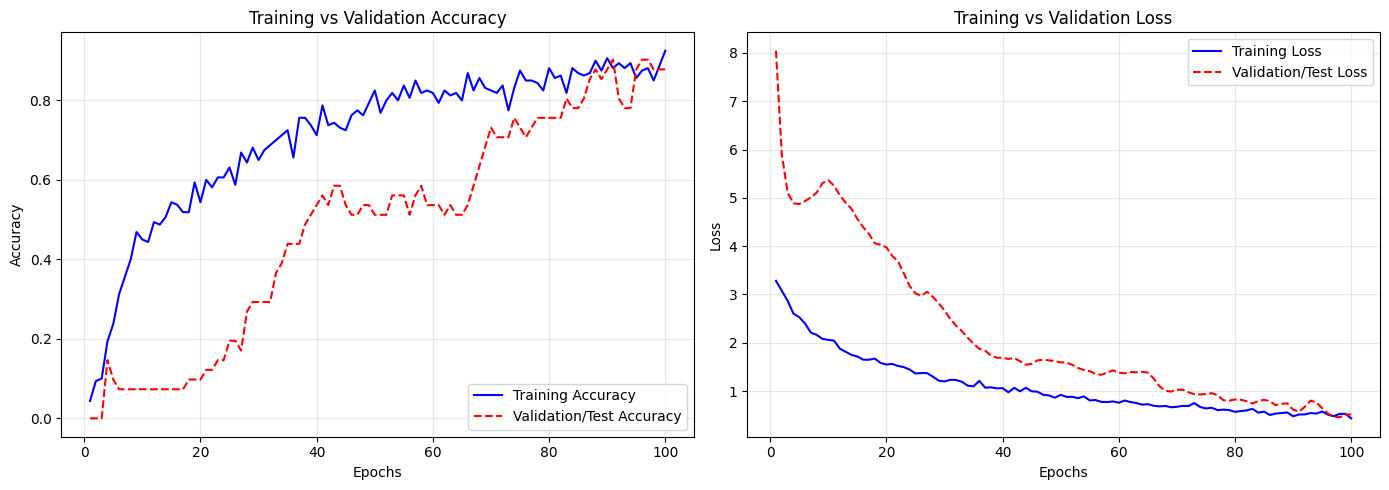

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Membuat frame gambar
plt.figure(figsize=(14, 5))

# --- GRAFIK 1: AKURASI (Accuracy) ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation/Test Accuracy', color='red', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# --- GRAFIK 2: LOSS (Kerugian) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation/Test Loss', color='red', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()